## BIDIRECTIONAL RNN for Cryptocurrency

Epoch 1/100
104/104 [==============================] - 16s 18ms/step - loss: 0.0630
Epoch 2/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0166
Epoch 3/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0101
Epoch 4/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0075
Epoch 5/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0060
Epoch 6/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0052
Epoch 7/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0044
Epoch 8/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0040
Epoch 9/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0035
Epoch 10/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0032
Epoch 11/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0030
Epoch 12/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0029


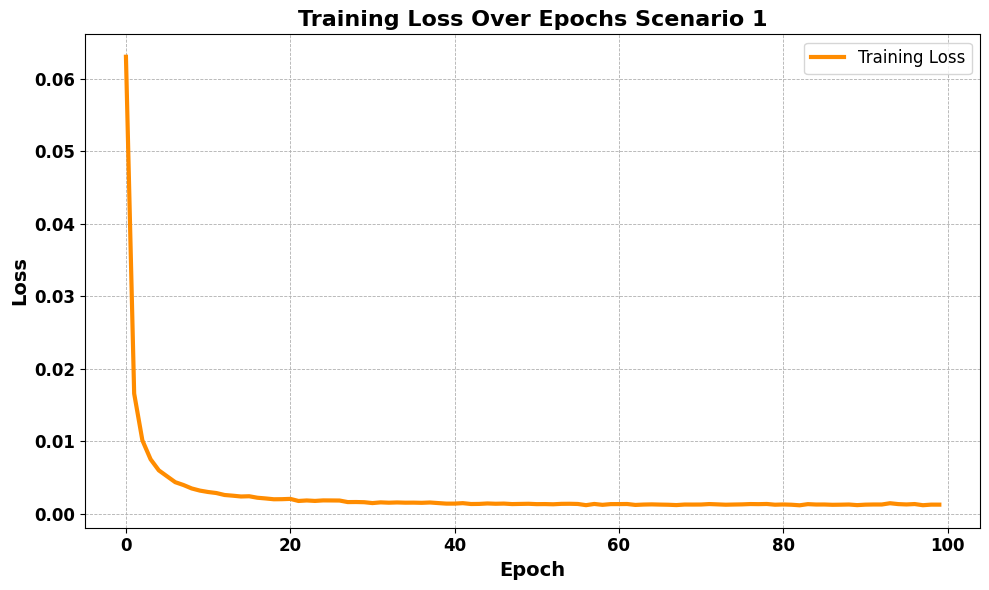

26/26 [==============================] - 3s 9ms/step


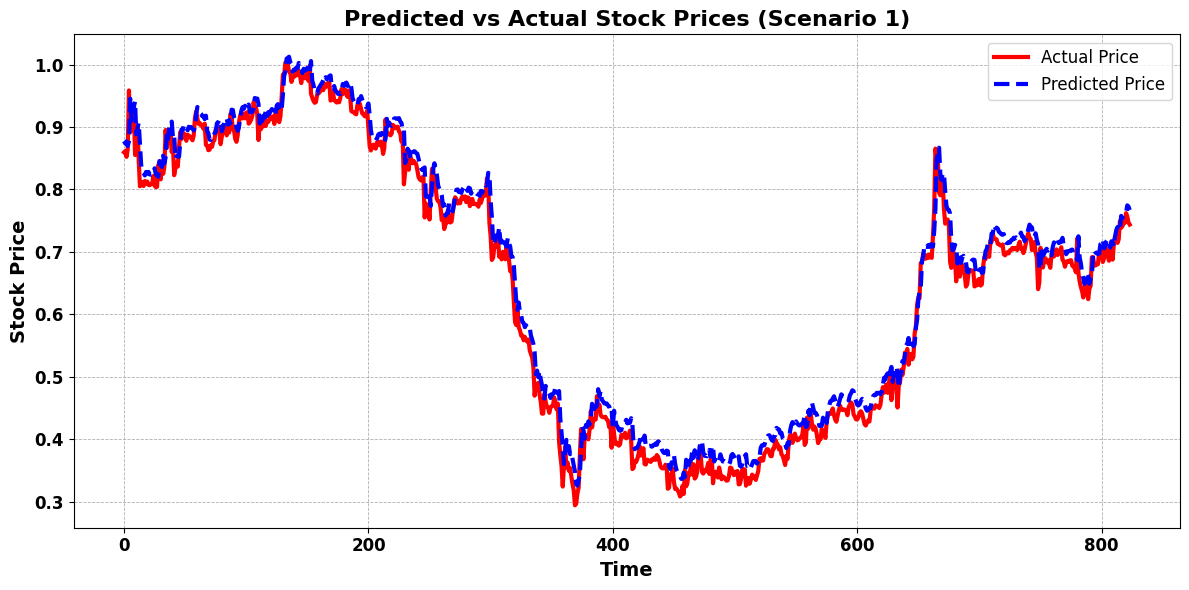

RMSE  : 0.0252
MSE   : 0.0006
MAPE  : 3.92%
R²    : 0.9863
D-Stat: 49.33%


In [5]:
# Untuk skenario pertama 3	3	32	0.2	Adam
# --- IMPORT LIBRARY ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.layers import Bidirectional
# --- LOAD DAN PREPROSES DATA ---
df = pd.read_csv('namecoin_usd_full.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df_close = df[['Date', 'Close']].copy()
df_close['Log_Close'] = np.log(df_close['Close'] + 1)

# --- OUTLIER DETECTION ---
Q1 = df_close['Log_Close'].quantile(0.25)
Q3 = df_close['Log_Close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_clean = df_close[(df_close['Log_Close'] >= lower_bound) & (df_close['Log_Close'] <= upper_bound)].copy()

# --- SPLIT TRAIN / TEST ---
split = int(len(df_clean) * 0.8)
train_data = df_clean.iloc[:split]
test_data = df_clean.iloc[split:]

# --- NORMALISASI ---
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Log_Close']])
test_scaled = scaler.transform(test_data[['Log_Close']])

# --- WINDOWING ---
def createDataset(data, window):
    X, Y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, 0])
        Y.append(data[i + window, 0])
    return np.array(X), np.array(Y)

window = 3
trainX, trainY = createDataset(train_scaled, window)
testX, testY = createDataset(test_scaled, window)
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

# --- BUILD MODEL SESUAI Scenario 1 ---
model = Sequential()
model.add(Bidirectional(SimpleRNN(32, activation='tanh', return_sequences=True), input_shape=(window, 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(SimpleRNN(32, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(SimpleRNN(32, activation='tanh')))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# --- TRAINING ---
#history = model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=1)
history = model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=1, validation_split=0.2)

# --- PLOT TRAINING LOSS ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='darkorange', linewidth=3)
plt.title('Training Loss Over Epochs Scenario 1', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.6)
plt.legend(fontsize=12)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

# Simpan ke file dengan resolusi tinggi (opsional)
plt.savefig('training_loss_plot1.png', dpi=300)

plt.show()


# --- PREDIKSI ---
predicted = model.predict(testX)
testY_inv = scaler.inverse_transform(testY.reshape(-1, 1))
predict_inv = scaler.inverse_transform(predicted)

# --- PLOT PREDIKSI VS AKTUAL ---
plt.figure(figsize=(12, 6))
plt.plot(testY_inv, label='Actual Price', color='red', linewidth=3)
plt.plot(predict_inv, label='Predicted Price', color='blue', linestyle='--', linewidth=3)
plt.title('Predicted vs Actual Stock Prices (Scenario 1)', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel('Stock Price', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.6)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

plt.savefig('predicted_vs_actual.png', dpi=300)

plt.show()


# --- METRIK EVALUASI ---
rmse = np.sqrt(mean_squared_error(testY_inv, predict_inv))
mse = mean_squared_error(testY_inv, predict_inv)
non_zero = testY_inv.flatten() != 0
mape = np.mean(np.abs((testY_inv.flatten()[non_zero] - predict_inv.flatten()[non_zero]) / testY_inv.flatten()[non_zero])) * 100
r2 = r2_score(testY_inv, predict_inv)

# --- D-STAT ---
def dstat(actual, pred):
    count = 0
    for i in range(len(actual) - 1):
        if (pred[i+1] - actual[i]) * (actual[i+1] - actual[i]) > 0:
            count += 1
    return (count / (len(actual) - 1)) * 100

dstat_score = dstat(testY_inv.flatten(), predict_inv.flatten())

print(f"RMSE  : {rmse:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"MAPE  : {mape:.2f}%")
print(f"R²    : {r2:.4f}")
print(f"D-Stat: {dstat_score:.2f}%")


Epoch 1/300
104/104 [==============================] - 20s 39ms/step - loss: 0.2985
Epoch 2/300
104/104 [==============================] - 4s 41ms/step - loss: 0.1082
Epoch 3/300
104/104 [==============================] - 4s 40ms/step - loss: 0.0592
Epoch 4/300
104/104 [==============================] - 4s 37ms/step - loss: 0.0372
Epoch 5/300
104/104 [==============================] - 4s 38ms/step - loss: 0.0247
Epoch 6/300
104/104 [==============================] - 4s 40ms/step - loss: 0.0185
Epoch 7/300
104/104 [==============================] - 4s 38ms/step - loss: 0.0153
Epoch 8/300
104/104 [==============================] - 4s 38ms/step - loss: 0.0126
Epoch 9/300
104/104 [==============================] - 4s 39ms/step - loss: 0.0104
Epoch 10/300
104/104 [==============================] - 4s 40ms/step - loss: 0.0091
Epoch 11/300
104/104 [==============================] - 4s 39ms/step - loss: 0.0077
Epoch 12/300
104/104 [==============================] - 4s 37ms/step - loss: 0.0070


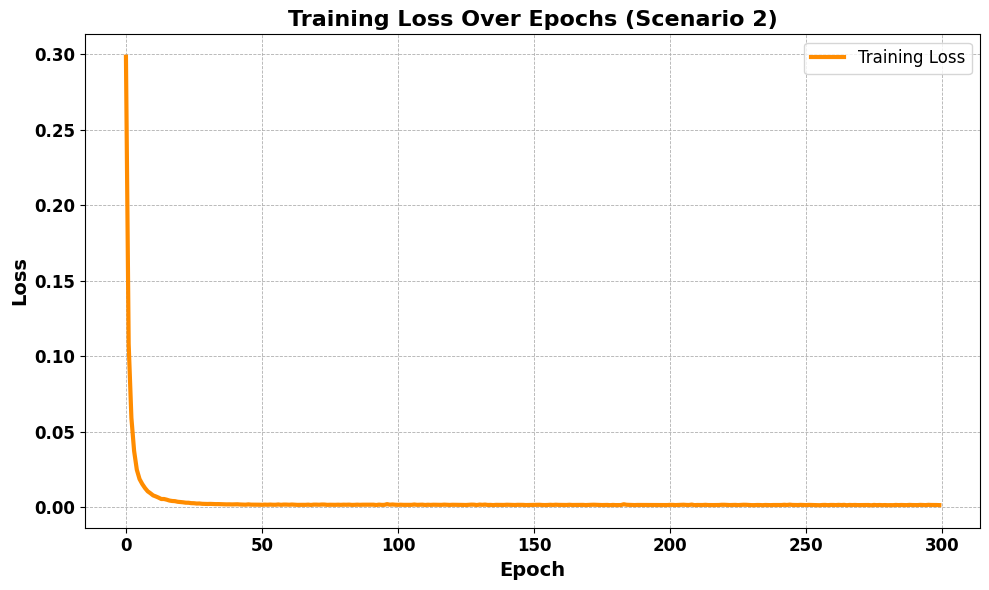

26/26 [==============================] - 1s 8ms/step


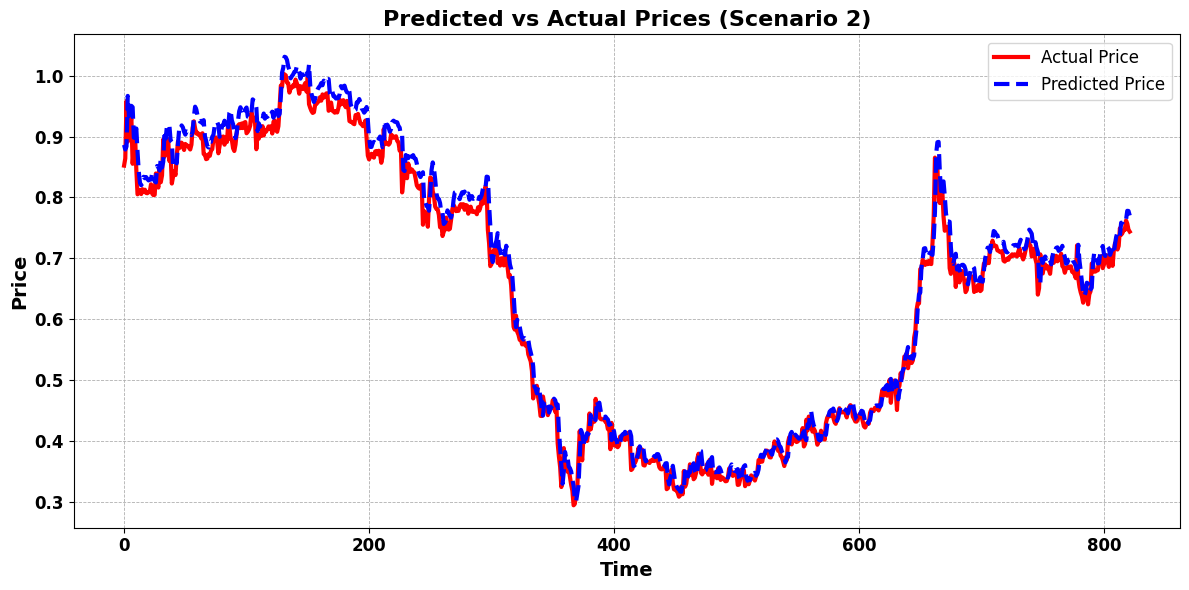

RMSE  : 0.0238
MSE   : 0.0006
MAPE  : 2.93%
R²    : 0.9878
D-Stat: 49.45%


In [12]:
#Skenario 2 
# --- IMPORT LIBRARY ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# --- LOAD DAN PREPROSES DATA ---
df = pd.read_csv('namecoin_usd_full.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df_close = df[['Date', 'Close']].copy()
df_close['Log_Close'] = np.log(df_close['Close'] + 1)

# --- OUTLIER DETECTION ---
Q1 = df_close['Log_Close'].quantile(0.25)
Q3 = df_close['Log_Close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_clean = df_close[(df_close['Log_Close'] >= lower_bound) & (df_close['Log_Close'] <= upper_bound)].copy()

# --- SPLIT TRAIN / TEST ---
split = int(len(df_clean) * 0.8)
train_data = df_clean.iloc[:split]
test_data = df_clean.iloc[split:]

# --- NORMALISASI ---
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Log_Close']])
test_scaled = scaler.transform(test_data[['Log_Close']])

# --- WINDOWING ---
def createDataset(data, window):
    X, Y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, 0])
        Y.append(data[i + window, 0])
    return np.array(X), np.array(Y)

window = 5  # Sesuai Skenario 2
trainX, trainY = createDataset(train_scaled, window)
testX, testY = createDataset(test_scaled, window)
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

# --- BUILD MODEL (Skenario 2) ---
model = Sequential()
model.add(Bidirectional(SimpleRNN(64, activation='tanh', return_sequences=True), input_shape=(window, 1)))
model.add(Dropout(0.3))
model.add(Bidirectional(SimpleRNN(64, activation='tanh', return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(SimpleRNN(64, activation='tanh', return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(SimpleRNN(64, activation='tanh')))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss='mean_squared_error')

# --- TRAIN MODEL ---
history = model.fit(trainX, trainY, epochs=300, batch_size=32, verbose=1)

# --- PLOT TRAINING LOSS ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='darkorange', linewidth=3)
plt.title('Training Loss Over Epochs (Scenario 2)', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Loss', fontsize=14, weight='bold')
plt.grid(True, linestyle='--', linewidth=0.6)
plt.legend(fontsize=12)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("training_loss_skenario2.png", dpi=300)
plt.show()

# --- PREDIKSI ---
predicted = model.predict(testX)
testY_inv = scaler.inverse_transform(testY.reshape(-1, 1))
predict_inv = scaler.inverse_transform(predicted)

# --- PLOT PREDIKSI VS AKTUAL ---
plt.figure(figsize=(12, 6))
plt.plot(testY_inv, label='Actual Price', color='red', linewidth=3)
plt.plot(predict_inv, label='Predicted Price', color='blue', linestyle='--', linewidth=3)
plt.title('Predicted vs Actual Prices (Scenario 2)', fontsize=16, weight='bold')
plt.xlabel('Time', fontsize=14, weight='bold')
plt.ylabel('Price', fontsize=14, weight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.6)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("prediksi_vs_aktual_skenario2.png", dpi=300)
plt.show()

# --- METRIK EVALUASI ---
rmse = np.sqrt(mean_squared_error(testY_inv, predict_inv))
mse = mean_squared_error(testY_inv, predict_inv)
non_zero = testY_inv.flatten() != 0
mape = np.mean(np.abs((testY_inv.flatten()[non_zero] - predict_inv.flatten()[non_zero]) / testY_inv.flatten()[non_zero])) * 100
r2 = r2_score(testY_inv, predict_inv)

# --- D-STAT ---
def dstat(actual, pred):
    count = 0
    for i in range(len(actual) - 1):
        if (pred[i+1] - actual[i]) * (actual[i+1] - actual[i]) > 0:
            count += 1
    return (count / (len(actual) - 1)) * 100

dstat_score = dstat(testY_inv.flatten(), predict_inv.flatten())

print(f"RMSE  : {rmse:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"MAPE  : {mape:.2f}%")
print(f"R²    : {r2:.4f}")
print(f"D-Stat: {dstat_score:.2f}%")


Epoch 1/600
104/104 [==============================] - 36s 76ms/step - loss: 1.2707
Epoch 2/600
104/104 [==============================] - 9s 83ms/step - loss: 0.4981
Epoch 3/600
104/104 [==============================] - 7s 71ms/step - loss: 0.2837
Epoch 4/600
104/104 [==============================] - 7s 67ms/step - loss: 0.1525
Epoch 5/600
104/104 [==============================] - 7s 65ms/step - loss: 0.0741
Epoch 6/600
104/104 [==============================] - 7s 69ms/step - loss: 0.0307
Epoch 7/600
104/104 [==============================] - 7s 68ms/step - loss: 0.0147
Epoch 8/600
104/104 [==============================] - 7s 65ms/step - loss: 0.0098
Epoch 9/600
104/104 [==============================] - 8s 78ms/step - loss: 0.0092
Epoch 10/600
104/104 [==============================] - 8s 75ms/step - loss: 0.0086
Epoch 11/600
104/104 [==============================] - 11s 103ms/step - loss: 0.0076
Epoch 12/600
104/104 [==============================] - 9s 88ms/step - loss: 0.007

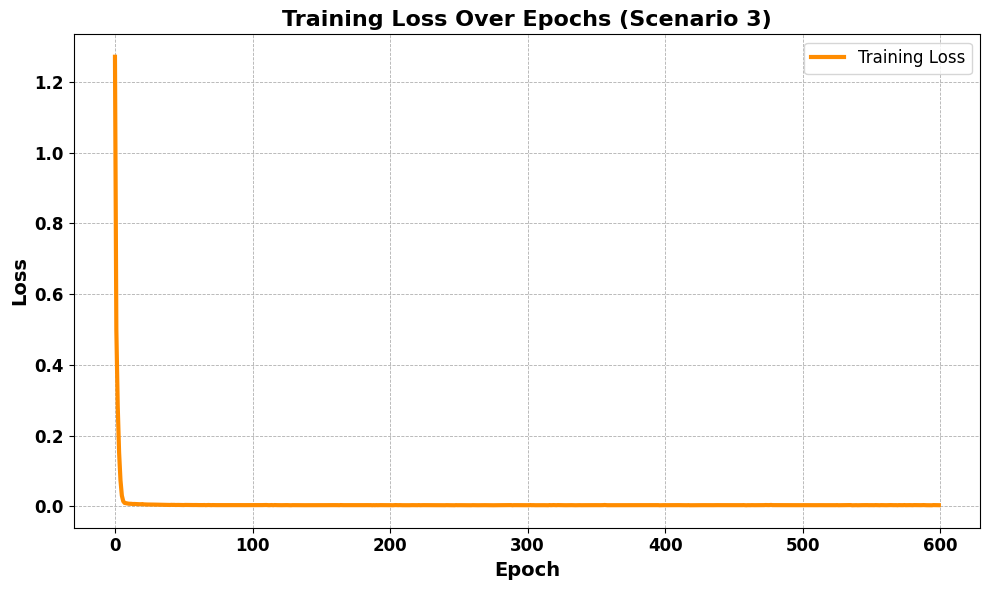

26/26 [==============================] - 6s 16ms/step


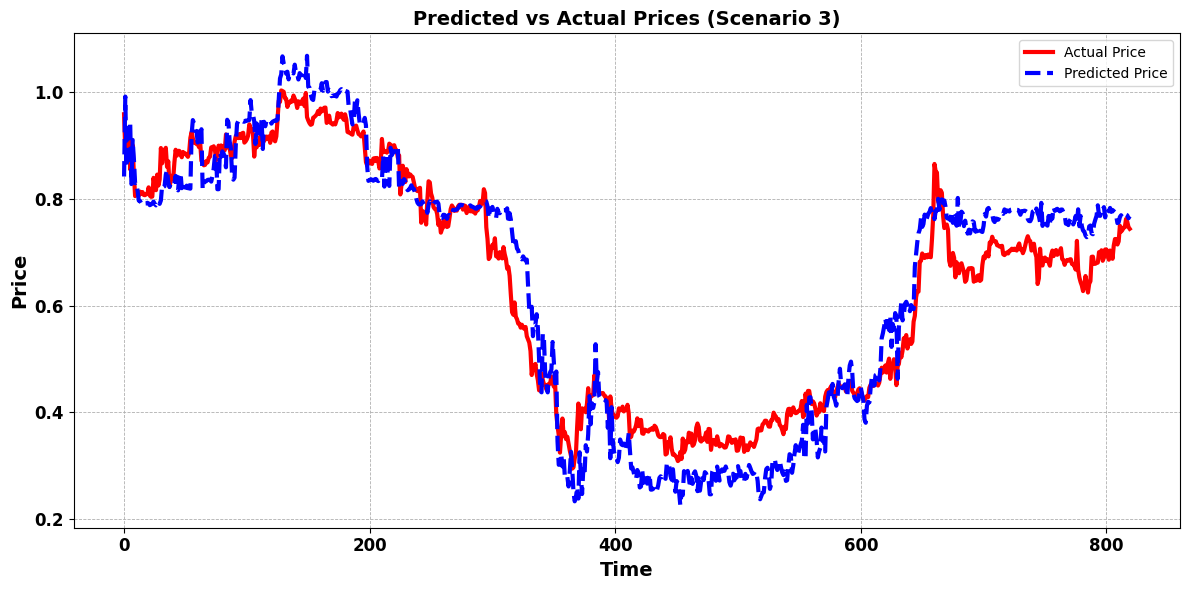

RMSE  : 0.0643
MSE   : 0.0041
MAPE  : 10.19%
R²    : 0.9108
D-Stat: 49.82%


In [13]:
#Skenario 3 
from tensorflow.keras.optimizers import RMSprop

# --- WINDOWING (Skenario 3) ---
window = 7
trainX, trainY = createDataset(train_scaled, window)
testX, testY = createDataset(test_scaled, window)
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

# --- BUILD MODEL (Skenario 3) ---
model = Sequential()
model.add(Bidirectional(SimpleRNN(100, activation='tanh', return_sequences=True), input_shape=(window, 1)))
model.add(Dropout(0.3))
model.add(Bidirectional(SimpleRNN(100, activation='tanh', return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(SimpleRNN(100, activation='tanh', return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(SimpleRNN(100, activation='tanh', return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(SimpleRNN(100, activation='tanh')))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mean_squared_error')

# --- TRAIN MODEL ---
history = model.fit(trainX, trainY, epochs=600, batch_size=32, verbose=1)

# --- PLOT TRAINING LOSS ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='darkorange', linewidth=3)
plt.title('Training Loss Over Epochs (Scenario 3)', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Loss', fontsize=14, weight='bold')
plt.grid(True, linestyle='--', linewidth=0.6)
plt.legend(fontsize=12)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("training_loss_skenario3.png", dpi=300)
plt.show()

# --- PREDIKSI & VISUALISASI ---
predicted = model.predict(testX)
testY_inv = scaler.inverse_transform(testY.reshape(-1, 1))
predict_inv = scaler.inverse_transform(predicted)

plt.figure(figsize=(12, 6))
plt.plot(testY_inv, label='Actual Price', color='red', linewidth=3)
plt.plot(predict_inv, label='Predicted Price', color='blue', linestyle='--', linewidth=3)
plt.title('Predicted vs Actual Prices (Scenario 3)', fontsize=14, weight='bold')
plt.xlabel('Time', fontsize=14, weight='bold')
plt.ylabel('Price', fontsize=14, weight='bold')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.6)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("prediksi_vs_aktual_skenario3.png", dpi=300)
plt.show()

# --- METRIK EVALUASI ---
rmse = np.sqrt(mean_squared_error(testY_inv, predict_inv))
mse = mean_squared_error(testY_inv, predict_inv)
non_zero = testY_inv.flatten() != 0
mape = np.mean(np.abs((testY_inv.flatten()[non_zero] - predict_inv.flatten()[non_zero]) / testY_inv.flatten()[non_zero])) * 100
r2 = r2_score(testY_inv, predict_inv)

def dstat(actual, pred):
    count = 0
    for i in range(len(actual) - 1):
        if (pred[i+1] - actual[i]) * (actual[i+1] - actual[i]) > 0:
            count += 1
    return (count / (len(actual) - 1)) * 100

dstat_score = dstat(testY_inv.flatten(), predict_inv.flatten())

print(f"RMSE  : {rmse:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"MAPE  : {mape:.2f}%")
print(f"R²    : {r2:.4f}")
print(f"D-Stat: {dstat_score:.2f}%")


Epoch 1/1000
104/104 [==============================] - 40s 115ms/step - loss: 0.3799
Epoch 2/1000
104/104 [==============================] - 12s 113ms/step - loss: 0.1132
Epoch 3/1000
104/104 [==============================] - 12s 116ms/step - loss: 0.0437
Epoch 4/1000
104/104 [==============================] - 12s 114ms/step - loss: 0.0241
Epoch 5/1000
104/104 [==============================] - 12s 115ms/step - loss: 0.0141
Epoch 6/1000
104/104 [==============================] - 12s 112ms/step - loss: 0.0102
Epoch 7/1000
104/104 [==============================] - 12s 112ms/step - loss: 0.0076
Epoch 8/1000
104/104 [==============================] - 12s 116ms/step - loss: 0.0068
Epoch 9/1000
104/104 [==============================] - 12s 113ms/step - loss: 0.0059
Epoch 10/1000
104/104 [==============================] - 12s 113ms/step - loss: 0.0059
Epoch 11/1000
104/104 [==============================] - 12s 114ms/step - loss: 0.0055
Epoch 12/1000
104/104 [=============================

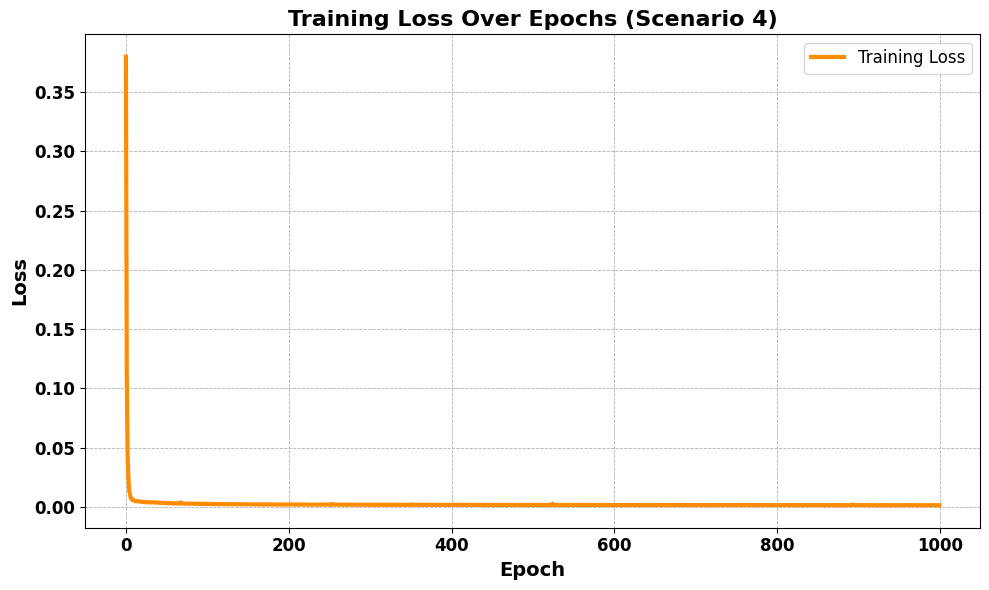

26/26 [==============================] - 3s 23ms/step


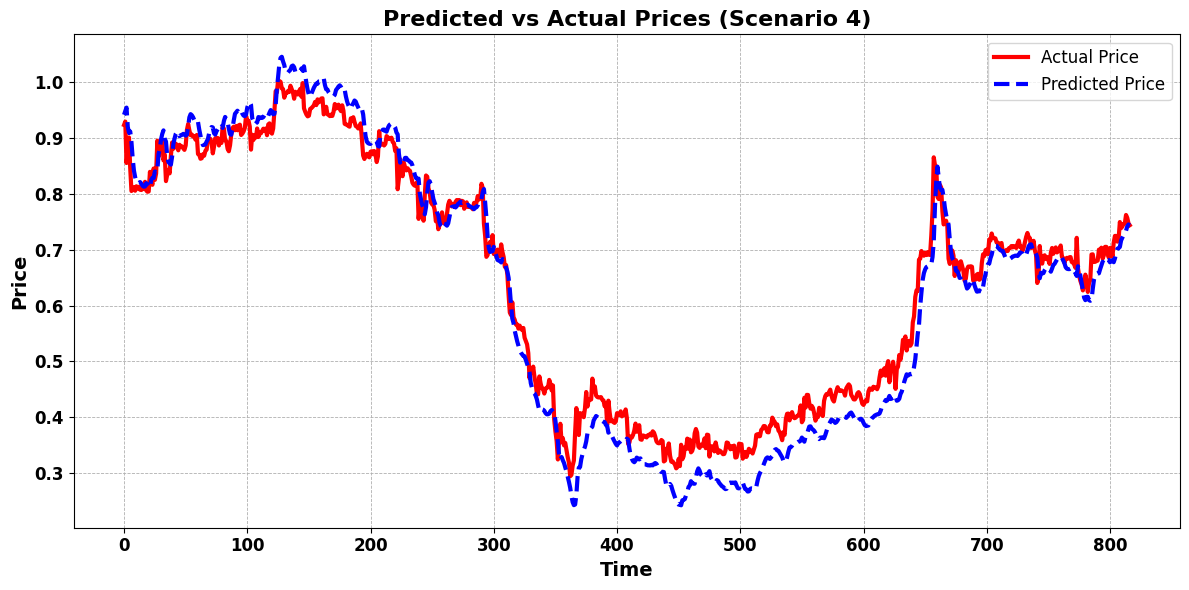

RMSE  : 0.0432
MSE   : 0.0019
MAPE  : 7.20%
R²    : 0.9597
D-Stat: 50.25%


In [8]:
#Skenario 4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

# --- LOAD DAN PREPROSES DATA ---
df = pd.read_csv('namecoin_usd_full.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df_close = df[['Date', 'Close']].copy()
df_close['Log_Close'] = np.log(df_close['Close'] + 1)

# --- OUTLIER DETECTION ---
Q1 = df_close['Log_Close'].quantile(0.25)
Q3 = df_close['Log_Close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_clean = df_close[(df_close['Log_Close'] >= lower_bound) & (df_close['Log_Close'] <= upper_bound)].copy()

# --- SPLIT TRAIN / TEST ---
split = int(len(df_clean) * 0.8)
train_data = df_clean.iloc[:split]
test_data = df_clean.iloc[split:]

# --- NORMALISASI ---
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Log_Close']])
test_scaled = scaler.transform(test_data[['Log_Close']])

# --- WINDOWING ---
def createDataset(data, window):
    X, Y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, 0])
        Y.append(data[i + window, 0])
    return np.array(X), np.array(Y)

# --- WINDOWING (Skenario 4) ---
window = 10
trainX, trainY = createDataset(train_scaled, window)
testX, testY = createDataset(test_scaled, window)
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

# --- BUILD MODEL (Skenario 4) ---
model = Sequential()
model.add(Bidirectional(SimpleRNN(128, activation='tanh', return_sequences=True), input_shape=(window, 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(SimpleRNN(128, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(SimpleRNN(128, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(SimpleRNN(128, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(SimpleRNN(128, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(SimpleRNN(128, activation='tanh')))
model.add(Dropout(0.2))
model.add(Dense(1))
#model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='mean_squared_error')
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='mean_squared_error')
# --- TRAIN MODEL ---
history = model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=1)

# --- PLOT TRAINING LOSS ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='darkorange', linewidth=3)
plt.title('Training Loss Over Epochs (Scenario 4)', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Loss', fontsize=14, weight='bold')
plt.grid(True, linestyle='--', linewidth=0.6)
plt.legend(fontsize=12)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("training_loss_skenario4.png", dpi=300)
plt.show()

# --- PREDIKSI & VISUALISASI ---
predicted = model.predict(testX)
testY_inv = scaler.inverse_transform(testY.reshape(-1, 1))
predict_inv = scaler.inverse_transform(predicted)

plt.figure(figsize=(12, 6))
plt.plot(testY_inv, label='Actual Price', color='red', linewidth=3)
plt.plot(predict_inv, label='Predicted Price', color='blue', linestyle='--', linewidth=3)
plt.title('Predicted vs Actual Prices (Scenario 4)', fontsize=16, weight='bold')
plt.xlabel('Time', fontsize=14, weight='bold')
plt.ylabel('Price', fontsize=14, weight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.6)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

plt.savefig("prediksi_vs_aktual_skenario4.png", dpi=300)
plt.show()

# --- METRIK EVALUASI ---
rmse = np.sqrt(mean_squared_error(testY_inv, predict_inv))
mse = mean_squared_error(testY_inv, predict_inv)
non_zero = testY_inv.flatten() != 0
mape = np.mean(np.abs((testY_inv.flatten()[non_zero] - predict_inv.flatten()[non_zero]) / testY_inv.flatten()[non_zero])) * 100
r2 = r2_score(testY_inv, predict_inv)

def dstat(actual, pred):
    count = 0
    for i in range(len(actual) - 1):
        if (pred[i+1] - actual[i]) * (actual[i+1] - actual[i]) > 0:
            count += 1
    return (count / (len(actual) - 1)) * 100

dstat_score = dstat(testY_inv.flatten(), predict_inv.flatten())

print(f"RMSE  : {rmse:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"MAPE  : {mape:.2f}%")
print(f"R²    : {r2:.4f}")
print(f"D-Stat: {dstat_score:.2f}%")


Jumlah data training: 3307 baris
Rentang tanggal training: 2013-11-08 sampai 2023-02-07

Jumlah data testing: 827 baris
Rentang tanggal testing: 2023-02-08 sampai 2025-05-14


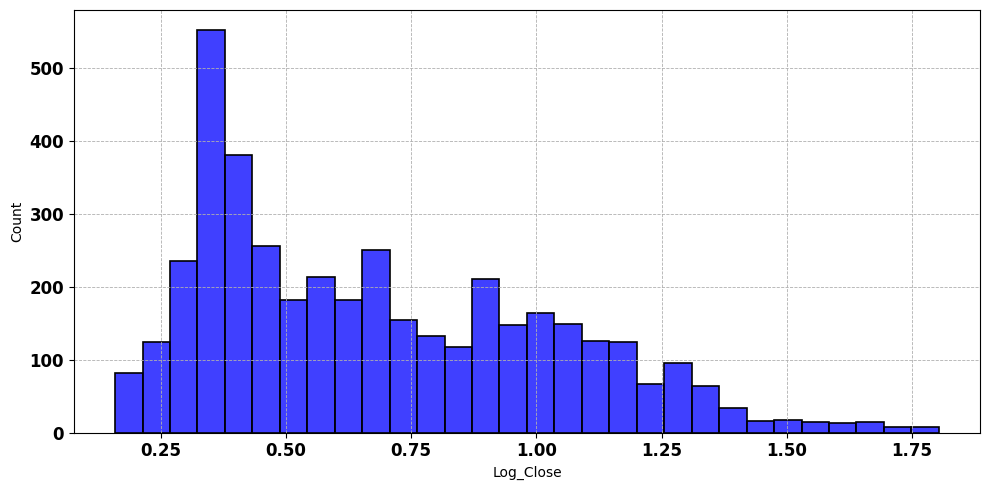

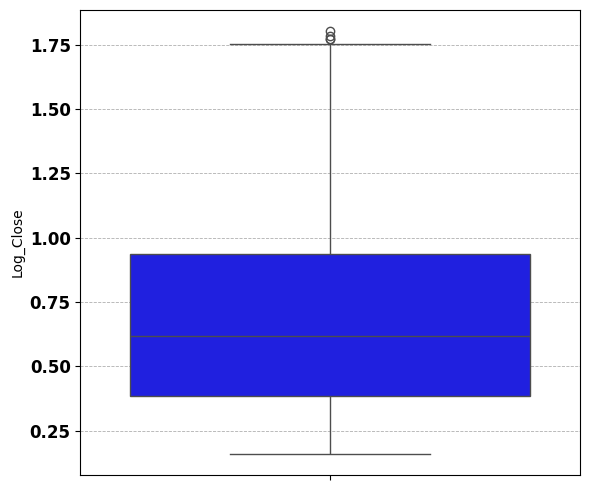

In [7]:
# --- IMPORT LIBRARY ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# --- LOAD DAN PREPROSES DATA ---
df = pd.read_csv('namecoin_usd_full.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df_close = df[['Date', 'Close']].copy()
df_close['Log_Close'] = np.log(df_close['Close'] + 1)

# --- OUTLIER DETECTION ---
Q1 = df_close['Log_Close'].quantile(0.25)
Q3 = df_close['Log_Close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_clean = df_close[(df_close['Log_Close'] >= lower_bound) & (df_close['Log_Close'] <= upper_bound)].copy()

# --- SPLIT DATA TRAIN/TEST ---
split = int(len(df_clean) * 0.8)
train_data = df_clean.iloc[:split]
test_data = df_clean.iloc[split:]

# --- INFORMASI TANGGAL DAN JUMLAH DATA ---
train_start = train_data['Date'].iloc[0].date()
train_end = train_data['Date'].iloc[-1].date()
test_start = test_data['Date'].iloc[0].date()
test_end = test_data['Date'].iloc[-1].date()

print(f"Jumlah data training: {len(train_data)} baris")
print(f"Rentang tanggal training: {train_start} sampai {train_end}\n")

print(f"Jumlah data testing: {len(test_data)} baris")
print(f"Rentang tanggal testing: {test_start} sampai {test_end}")

# --- HISTOGRAM ---
plt.figure(figsize=(10, 5))
sns.histplot(df_clean['Log_Close'], bins=30, color='blue', edgecolor='black', linewidth=1.2)
#plt.title('Distribusi Log Harga (Histogram)', fontsize=16, fontweight='bold')
#plt.xlabel('Log Harga', fontsize=14, fontweight='bold')
#plt.ylabel('Frekuensi', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.6)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('histogram_log_close.png', dpi=300)
plt.show()

# --- BOXPLOT ---
plt.figure(figsize=(6, 5))
sns.boxplot(y=df_clean['Log_Close'], color='blue')
#plt.title('Boxplot Log Harga', fontsize=16, fontweight='bold')
#plt.ylabel('Log Harga', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.6, axis='y')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('boxplot_log_close.png', dpi=300)
plt.show()


In [ ]:
#CORETAN 


Epoch 1/100
104/104 [==============================] - 16s 18ms/step - loss: 0.0599
Epoch 2/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0167
Epoch 3/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0102
Epoch 4/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0078
Epoch 5/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0061
Epoch 6/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0052
Epoch 7/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0040
Epoch 8/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0039
Epoch 9/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0037
Epoch 10/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0032
Epoch 11/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0031
Epoch 12/100
104/104 [==============================] - 2s 18ms/step - loss: 0.0028


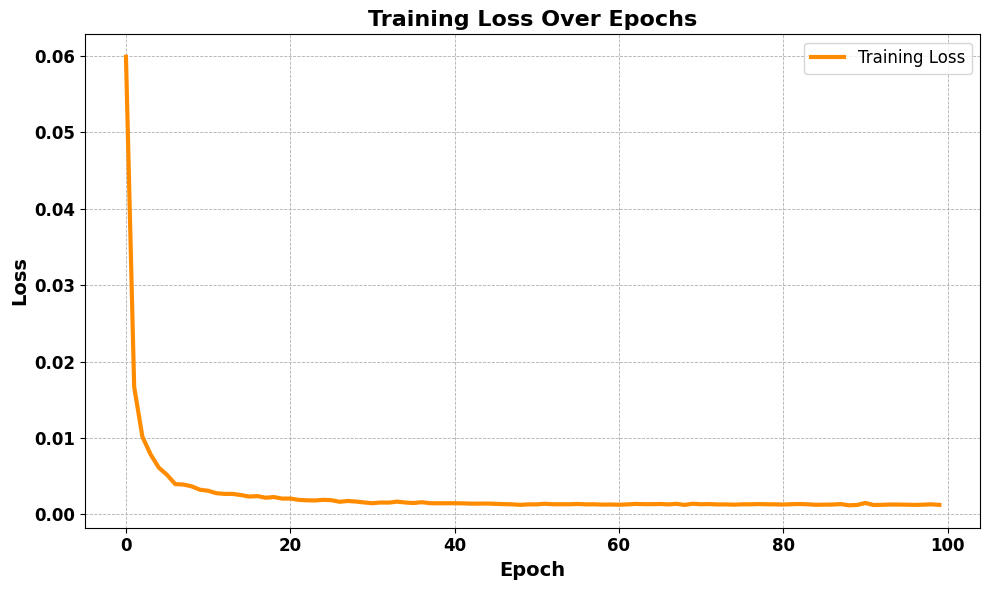

26/26 [==============================] - 4s 8ms/step
RMSE  : 0.0201
MSE   : 0.0004
MAPE  : 2.79%
R²    : 0.9913
D-Stat: 66.34%
       Actual  Predicted
0    0.859509   0.852820
1    0.861623   0.848819
2    0.852285   0.853318
3    0.864155   0.845789
4    0.958584   0.853282
..        ...        ...
819  0.746688   0.740670
820  0.762207   0.741967
821  0.757061   0.753395
822  0.747162   0.751501
823  0.743840   0.747050

[824 rows x 2 columns]


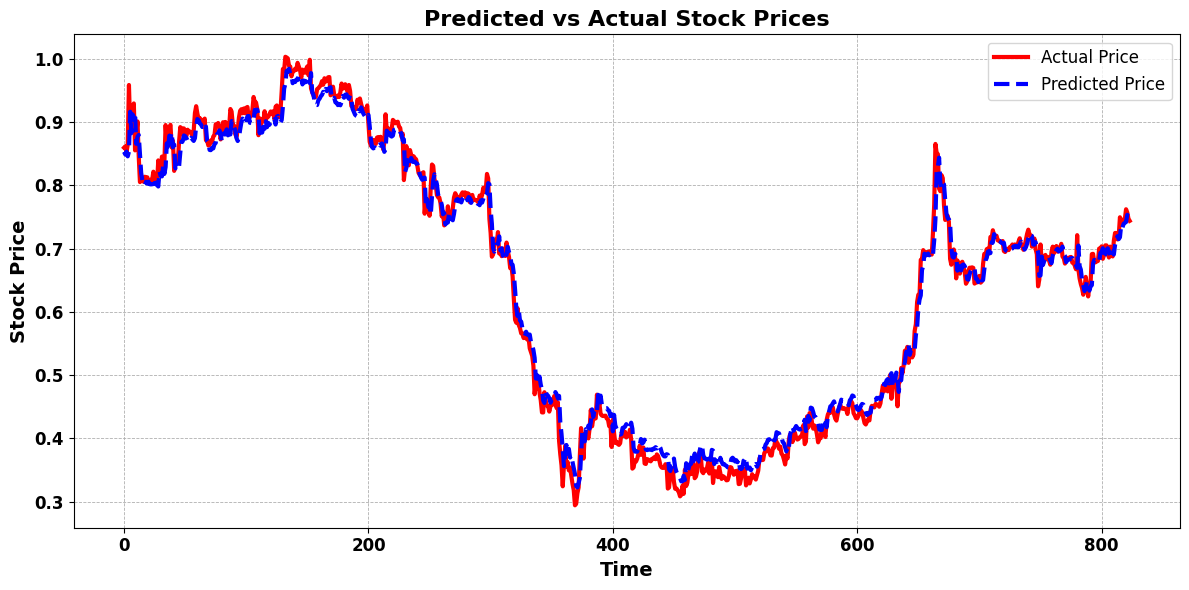

In [2]:
# --- IMPORT LIBRARY ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Bidirectional

# --- LOAD DAN PREPROSES DATA ---
df = pd.read_csv('namecoin_usd_full.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df_close = df[['Date', 'Close']].copy()
df_close['Log_Close'] = np.log(df_close['Close'] + 1)

# --- OUTLIER DETECTION ---
Q1 = df_close['Log_Close'].quantile(0.25)
Q3 = df_close['Log_Close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_clean = df_close[(df_close['Log_Close'] >= lower_bound) & (df_close['Log_Close'] <= upper_bound)].copy()

# --- SPLIT TRAIN / TEST ---
split = int(len(df_clean) * 0.8)
train_data = df_clean.iloc[:split]
test_data = df_clean.iloc[split:]

# --- NORMALISASI ---
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Log_Close']])
test_scaled = scaler.transform(test_data[['Log_Close']])

# --- WINDOWING ---
def createDataset(data, window):
    X, Y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, 0])
        Y.append(data[i + window, 0])
    return np.array(X), np.array(Y)

window = 3
trainX, trainY = createDataset(train_scaled, window)
testX, testY = createDataset(test_scaled, window)

trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

# --- BUILD MODEL ---
model = Sequential()
model.add(Bidirectional(SimpleRNN(32, activation='tanh', return_sequences=True), input_shape=(window, 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(SimpleRNN(32, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(SimpleRNN(32, activation='tanh')))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# --- TRAINING TANPA VALIDATION ---
history = model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=1)

# --- PLOT TRAINING LOSS ONLY ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='darkorange', linewidth=3)
plt.title('Training Loss Over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.6)
plt.legend(fontsize=12)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# --- PREDIKSI ---
predicted = model.predict(testX)
testY_inv = scaler.inverse_transform(testY.reshape(-1, 1))
predict_inv = scaler.inverse_transform(predicted)

# --- METRIK EVALUASI ---
rmse = np.sqrt(mean_squared_error(testY_inv, predict_inv))
mse = mean_squared_error(testY_inv, predict_inv)
non_zero = testY_inv.flatten() != 0
mape = np.mean(np.abs((testY_inv.flatten()[non_zero] - predict_inv.flatten()[non_zero]) / testY_inv.flatten()[non_zero])) * 100
r2 = r2_score(testY_inv, predict_inv)

def dstat(x, y):
    count = 0
    n = len(y)
    for i in range(n - 1):
        if (x[i + 1] - y[i]) * (y[i + 1] - y[i]) > 0:
            count += 1
    return (count / (n - 1)) * 100

dstat_score = dstat(testY_inv.flatten(), predict_inv.flatten())

print(f"RMSE  : {rmse:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"MAPE  : {mape:.2f}%")
print(f"R²    : {r2:.4f}")
print(f"D-Stat: {dstat_score:.2f}%")

# --- DATAFRAME PREDIKSI VS AKTUAL ---
dfpredict = pd.DataFrame({
    'Actual': testY_inv.flatten(),
    'Predicted': predict_inv.flatten()
})
print(dfpredict)

# --- PLOT PREDIKSI VS AKTUAL ---
plt.figure(figsize=(12, 6))
plt.plot(testY_inv, label='Actual Price', color='red', linewidth=3)
plt.plot(predict_inv, label='Predicted Price', color='blue', linestyle='--', linewidth=3)
plt.title('Predicted vs Actual Stock Prices', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel('Stock Price', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.6)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()
